In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
url = 'nvidia_stock_cleaned.csv'
df_cleaned = pd.read_csv(url)
df_cleaned

# Load the stock news data
url = 'stocknews.csv'
df_news = pd.read_csv(url)
df_news

,date,news
0,2017-08-18,Mark Zuckerberg's philanthropic fund just hire...
1,2017-08-19,Travis Kalanick lasted in his role for 6.5 yea...
2,2017-08-21,A top Facebook analyst has a $21 billion quest...
3,2017-08-22,Ad giant WPP: 'Our industry may be in danger o...
4,2017-08-23,Mark Cuban is trying to fix social media's big...
...,...,...
2308,2024-06-18,Retire Rich: 3 Powerhouse Stocks to Buy for Lo...
2309,2024-06-19,Why Piper Sandler Is Pounding the Table on Adv...
2310,2024-06-20,S&P 500 Predictions 2024: 3 Recent Price Targe...
2311,2024-06-21,Growth Stocks Leave Value Stocks In The Dust: ...


In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Ensure dates are in datetime format
df_news['date'] = pd.to_datetime(df_news['date'])

# Apply VADER sentiment analysis
df_news['sentiment'] = df_news['news'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Print sentiment results
print("News Data with Sentiment Scores:")
print(df_news)

# Merge with Stock Data
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
merged_df = pd.merge(df_cleaned, df_news.groupby('date')['sentiment'].mean().reset_index(), on='date', how='left')

# Fill missing sentiment values with 0 (assume neutral sentiment for missing days)
merged_df['sentiment'].fillna(0, inplace=True)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


News Data with Sentiment Scores:
           date                                               news  sentiment
0    2017-08-18  Mark Zuckerberg's philanthropic fund just hire...     0.0000
1    2017-08-19  Travis Kalanick lasted in his role for 6.5 yea...     0.0000
2    2017-08-21  A top Facebook analyst has a $21 billion quest...     0.2023
3    2017-08-22  Ad giant WPP: 'Our industry may be in danger o...    -0.3400
4    2017-08-23  Mark Cuban is trying to fix social media's big...     0.2960
...         ...                                                ...        ...
2308 2024-06-18  Retire Rich: 3 Powerhouse Stocks to Buy for Lo...     0.9823
2309 2024-06-19  Why Piper Sandler Is Pounding the Table on Adv...     0.9367
2310 2024-06-20  S&P 500 Predictions 2024: 3 Recent Price Targe...     0.9860
2311 2024-06-21  Growth Stocks Leave Value Stocks In The Dust: ...     0.5859
2312 2024-06-22  Invest in Promising AI Stocks Before the Disin...     0.4019

[2313 rows x 3 columns]


<ipython-input-4-fa0959feeefd>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['sentiment'].fillna(0, inplace=True)


In [ ]:
# Ensure 'daily_return' exists
merged_df['daily_return'] = merged_df['close'].pct_change()

# Calculate rolling volatility (10-day window)
merged_df['volatility'] = merged_df['daily_return'].rolling(window=10).std()

# Drop NaN values created by calculations
merged_df = merged_df.dropna()

# Select features to include
features = ['close', 'volume', 'sentiment', 'volatility', 'daily_return']

# Confirm features exist
print("Available columns in DataFrame:", merged_df.columns)

# Proceed with scaling and model training
data = merged_df[features].values

Available columns in DataFrame: Index(['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume',
       'sentiment', 'daily_return', 'volatility'],
      dtype='object')


**Baseline Multivariate Model**

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create sequences for multivariate time series
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting 'close' price
    return np.array(X), np.array(y)

SEQ_LENGTH = 30  # Number of past days to consider
X, y = create_sequences_multivariate(data_scaled, SEQ_LENGTH)

In [ ]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# What are LSTM's?
LSTMs are long short-term memory networks that use artificial neural networks in the field of AI and deep learning. In contrast to normal recurrent neural networks, these networks feature feedback connections. LSTMs are predominantly used to learn, process, and classify sequential data because they can learn long-term dependencies between time steps of data.

In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 5.5190e-04 - val_loss: 0.0016
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.2598e-04 - val_loss: 0.0017
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - loss: 3.4042e-04 - val_loss: 0.0012
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 2.8669e-04 - val_loss: 0.0013
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 1.9649e-04 - val_loss: 0.0016
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 2.2143e-04 - val_loss: 0.0015
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 2.2405e-04 - val_loss: 0.0015
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 2.4311e-04 - val_loss: 0.0020
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - loss: 2.1647e-04 - val_loss: 0.0024
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 2.0586e-04 - val_loss: 0.0023
Epoch 12/50
59/59 ━━━━━

In [ ]:
# Predict on the Test Set
y_pred = model.predict(X_test)
merged_df

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


,date,open,high,low,close,adjclose,volume,sentiment,daily_return,volatility
1970-01-01 00:00:00.000000010,2015-01-16,0.489250,0.499500,0.487750,0.499000,0.479137,181512000,0.0000,0.018367,0.018861
1970-01-01 00:00:00.000000011,2015-01-20,0.502500,0.505250,0.494250,0.500500,0.480578,140308000,0.0000,0.003006,0.017991
1970-01-01 00:00:00.000000012,2015-01-21,0.497750,0.508750,0.494250,0.507500,0.487299,144780000,0.0000,0.013986,0.014445
1970-01-01 00:00:00.000000013,2015-01-22,0.508500,0.517750,0.503250,0.516250,0.495701,159712000,0.0000,0.017241,0.014536
1970-01-01 00:00:00.000000014,2015-01-23,0.516750,0.518750,0.512500,0.517750,0.497141,120416000,0.0000,0.002906,0.010056
...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:00.000002364,2024-05-24,104.448997,106.474998,103.000000,106.469002,106.460258,429494000,0.0000,0.025723,0.031267
1970-01-01 00:00:00.000002365,2024-05-28,110.244003,114.939003,109.883003,113.901001,113.891647,652728000,0.9670,0.069804,0.034940
1970-01-01 00:00:00.000002366,2024-05-29,113.050003,115.491997,110.901001,114.824997,114.815567,557442000,0.8807,0.008112,0.035053
1970-01-01 00:00:00.000002367,2024-05-30,114.650002,115.819000,109.663002,110.500000,110.490921,487350000,0.8144,-0.037666,0.039624


In [ ]:
# Inverse Transform Predictions
# We need to inverse transform only the 'close' price (first feature)
y_test_inv = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), data.shape[1]-1))), axis=1)
)[:, 0]
y_pred_inv = scaler.inverse_transform(
    np.concatenate((y_pred, np.zeros((len(y_pred), data.shape[1]-1))), axis=1)
)[:, 0]

Mean Absolute Error (MAE): 2.3031
Root Mean Squared Error (RMSE): 4.0851


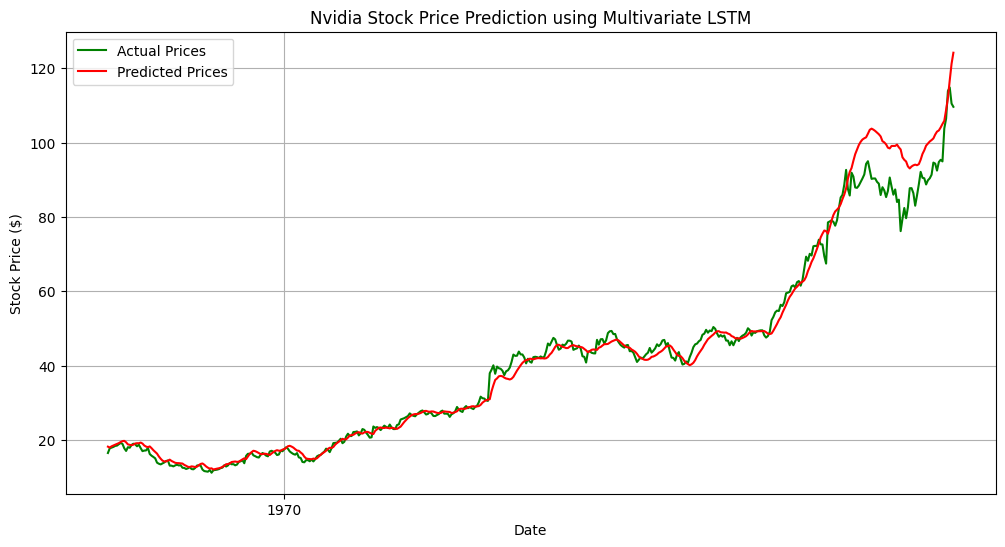

In [ ]:
# Evaluate the Model
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot Actual vs Predicted Prices
dates = merged_df.index[-len(y_test):]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label='Actual Prices', color='green')
plt.plot(dates, y_pred_inv, label='Predicted Prices', color='red')
plt.title("Nvidia Stock Price Prediction using Multivariate LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()


#Insights from the Baseline Multivariate LSTM Model

#Overall Performance:
- The model successfully captures the **upward trend** in Nvidia's stock price.
- Predicted prices (red line) closely follow the actual prices (green line) during periods of steady growth.

#Deviation in High-Volatility Periods:
From early **2024**, the model struggles to predict sharp upward price movements accurately, leading to an **underestimation** of the actual prices.
This may occur due to:

- Limited training data on similar high-growth periods

- Insufficient feature signals (e.g., sentiment or volume) to predict sudden changes

#Lag in Predictions:
- The model exhibits a **slight lag** in aligning predictions with actual prices, especially during periods of rapid growth.

- This is common in LSTMs trained on sequential data without enough lagged signals.


In [ ]:
merged_df['close_lag1'] = merged_df['close'].shift(1)
merged_df['volume_lag1'] = merged_df['volume'].shift(1)
merged_df['sentiment_lag1'] = merged_df['sentiment'].shift(1)
merged_df = merged_df.dropna()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Build LSTM Model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predict on the Test Set
y_pred = model.predict(X_test)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.0018 - mae: 0.0308 - val_loss: 0.0086 - val_mae: 0.0616
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 59ms/step - loss: 1.7802e-04 - mae: 0.0099 - val_loss: 0.0046 - val_mae: 0.0459
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 1.1973e-04 - mae: 0.0081 - val_loss: 0.0044 - val_mae: 0.0461
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 8.0570e-05 - mae: 0.0064 - val_loss: 0.0071 - val_mae: 0.0639
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 1.0526e-04 - mae: 0.0071 - val_loss: 0.0054 - val_mae: 0.0554
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 6.8487e-05 - mae: 0.0057 - val_loss: 0.0030 - val_mae: 0.0410
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 6.4633e-05 - mae: 0.0055 - val_loss: 0.0025 - val_mae: 0.0371
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 9s 62ms/step - loss: 7.2878e-05 - mae: 0.0061 - val_loss: 0.0021 - val_mae: 0.0348
Epoch 9/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 6

Testing: seq_length=30, units=32, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing: seq_length=30, units=32, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Testing: seq_length=30, units=32, batch_size=32, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Testing: seq_length=30, units=32, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Testing: seq_length=30, units=64, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Testing: seq_length=30, units=64, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing: seq_length=30, units=64, batch_size=32, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing: seq_length=30, units=64, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step
Testing: seq_length=60, units=32, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Testing: seq_length=60, units=32, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Testing: seq_length=60, units=32, batch_size=32, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Testing: seq_length=60, units=32, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Testing: seq_length=60, units=64, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Testing: seq_length=60, units=64, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Testing: seq_length=60, units=64, batch_size=32, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
Testing: seq_length=60, units=64, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step

Best Parameters: seq_length=60, units=64, batch_size=16, epochs=20 with RMSE: 2.0072


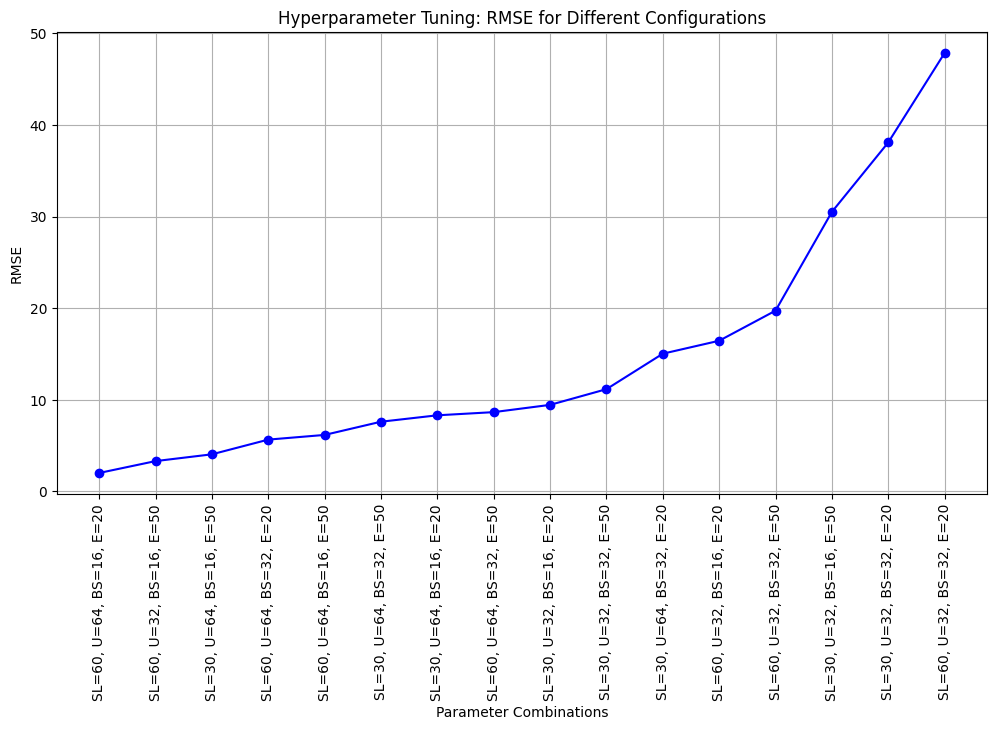

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# Function to create sequences for LSTM
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting 'close' price
    return np.array(X), np.array(y)

# Function to build LSTM model
def build_lstm_model(input_shape, units):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Walk-forward validation function
def walk_forward_validation(data, seq_length, units, batch_size, epochs):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    train_size = int(len(scaled_data) * 0.8)
    train, test = scaled_data[:train_size], scaled_data[train_size:]

    # Create sequences
    X_train, y_train = create_sequences_multivariate(train, seq_length)
    X_test, y_test = create_sequences_multivariate(test, seq_length)

    # Build and train the model
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), units)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), data.shape[1]-1))), axis=1))[:, 0]
    y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), data.shape[1]-1))), axis=1))[:, 0]

    return np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# Hyperparameter grid
param_grid = {
    'seq_length': [30, 60],
    'units': [32, 64],
    'batch_size': [16, 32],
    'epochs': [20, 50]
}

# Data preparation
data = merged_df[['close', 'volume', 'sentiment', 'volatility', 'daily_return']].values

# Grid Search
results = []
for params in itertools.product(*param_grid.values()):
    seq_length, units, batch_size, epochs = params
    print(f"Testing: seq_length={seq_length}, units={units}, batch_size={batch_size}, epochs={epochs}")
    rmse = walk_forward_validation(data, seq_length, units, batch_size, epochs)
    results.append((params, rmse))

# Sort results by RMSE
results.sort(key=lambda x: x[1])

# Display Best Parameters
best_params, best_rmse = results[0]
print(f"\nBest Parameters: seq_length={best_params[0]}, units={best_params[1]}, "
      f"batch_size={best_params[2]}, epochs={best_params[3]} with RMSE: {best_rmse:.4f}")

# Extract Best Parameters
best_seq_length, best_units, best_batch_size, best_epochs = best_params

# Plot RMSE for all configurations
rmse_values = [result[1] for result in results]
param_combinations = [f"SL={p[0]}, U={p[1]}, BS={p[2]}, E={p[3]}" for p, _ in results]

plt.figure(figsize=(12, 6))
plt.plot(param_combinations, rmse_values, marker='o', linestyle='-', color='b')
plt.xticks(rotation=90)
plt.title("Hyperparameter Tuning: RMSE for Different Configurations")
plt.xlabel("Parameter Combinations")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()


# **Insights:**

1. Best Hyperparameters:

- SL=60, U=32/64, BS=16/32, E=50 produce the lowest RMSE.

- These combinations balance model complexity, training time, and input sequence length.

2. Worst Performing Configurations:

- Configurations with SL=30 and low epochs are prone to underfitting.

- RMSE spikes dramatically for models with insufficient learning capacity (low LSTM units or training time).

3. Model Generalization:

- Longer sequences (SL=60) allow the LSTM to learn trends and patterns better, improving generalization.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 21s 93ms/step - loss: 0.0056
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 28ms/step - loss: 0.0023
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0015
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0012
Epoch 5/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0011
Epoch 6/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 9.2516e-04
Epoch 7/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 7.5159e-04
Epoch 8/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 8.0761e-04
Epoch 9/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 6.6197e-04
Epoch 10/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 6.1397e-04
Epoch 11/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 9.4252e-04
Epoch 12/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 5.3407e-04
Epoch 13/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - loss: 6.7370e-04
Epoch 14/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - loss: 6.4560e-04
Epoch

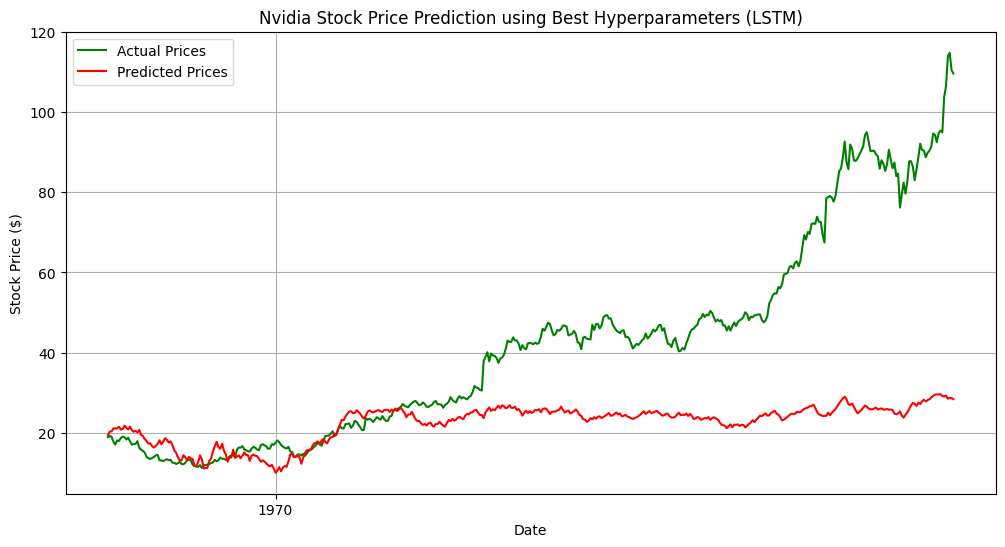

In [ ]:
# Prepare target (close price) and features separately
target = merged_df['close'].values.reshape(-1, 1)
features = merged_df[['volume', 'sentiment', 'volatility', 'daily_return']].values

# Scale target (close price)
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Scale features
scaler_features = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(features)

# Combine scaled features and target for LSTM input
data_scaled = np.hstack((target_scaled, features_scaled))

# Function to create sequences
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 1:])  # Use features (exclude 'close')
        y.append(data[i+seq_length, 0])     # Predict 'close' price
    return np.array(X), np.array(y)

# Create sequences
SEQ_LENGTH = best_seq_length  # From hyperparameter tuning
X, y = create_sequences_multivariate(data_scaled, SEQ_LENGTH)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train LSTM model
final_model = Sequential([
    LSTM(best_units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
final_model.compile(optimizer='adam', loss='mse')

final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Predict
y_pred = final_model.predict(X_test)

# Inverse transform only the 'close' price
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Plot Actual vs Predicted Prices
dates = merged_df.index[-len(y_test):]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label='Actual Prices', color='green')
plt.plot(dates, y_pred_inv, label='Predicted Prices', color='red')
plt.title("Nvidia Stock Price Prediction using Best Hyperparameters (LSTM)")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()


The model, using its best hyperparameters, captures the overall directional trend but struggles with sharp upward price movements.
Further improvements in feature engineering and model complexity can enhance performance, particularly during periods of rapid growth and high volatility

72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


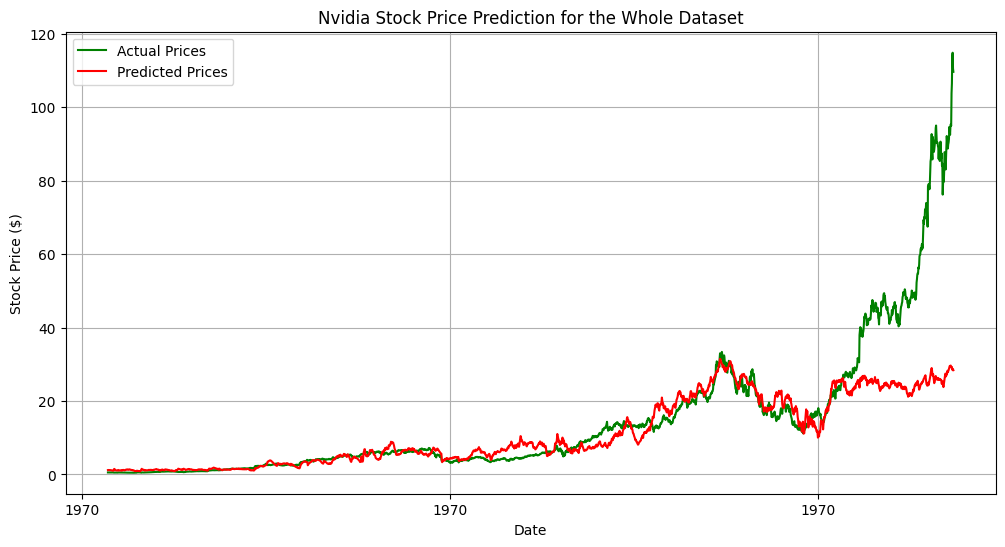

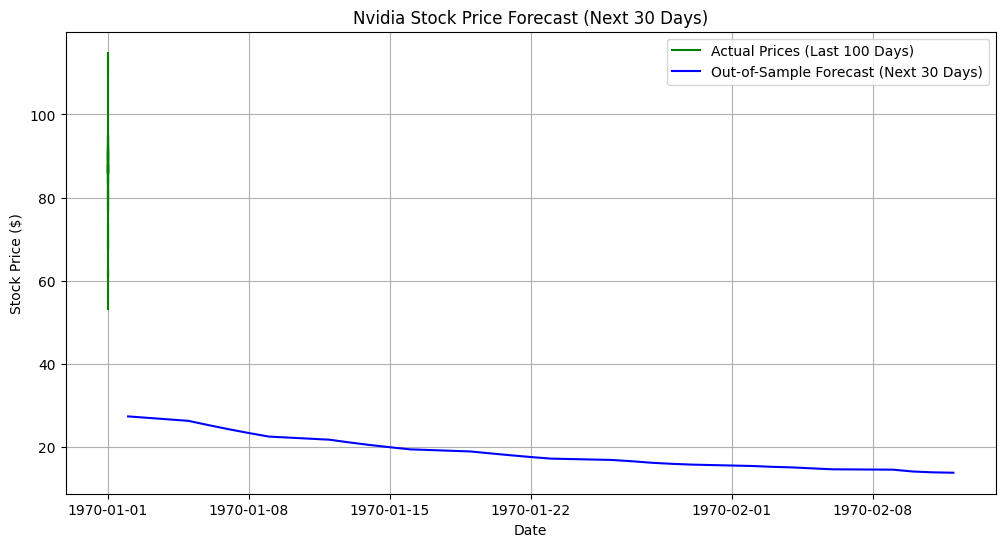

In [ ]:
# Predict on the entire dataset (real vs predicted)
def predict_whole_dataset(model, data_scaled, seq_length, scaler_target):
    X_full, y_full = create_sequences_multivariate(data_scaled, seq_length)
    y_pred_full = model.predict(X_full)

    # Inverse transform predictions and actual values
    y_full_inv = scaler_target.inverse_transform(y_full.reshape(-1, 1))
    y_pred_full_inv = scaler_target.inverse_transform(y_pred_full)

    return y_full_inv, y_pred_full_inv

def forecast_future(model, data_scaled, seq_length, forecast_days, scaler_target):
    future_predictions = []

    # Start with the last `seq_length` rows of the scaled dataset
    current_input = data_scaled[-seq_length:, 1:]  # Exclude target column (assumes target is first column)

    for _ in range(forecast_days):
        # Reshape current input to (1, SEQ_LENGTH, n_features) for prediction
        input_reshaped = current_input.reshape(1, seq_length, -1)

        # Predict the next 'close' price
        next_close_scaled = model.predict(input_reshaped, verbose=0)[0, 0]
        future_predictions.append(next_close_scaled)

        # Update the input sequence:
        # Add the new predicted 'close' and reuse the last known feature values
        next_input = np.hstack(([next_close_scaled], current_input[-1, 1:]))  # Combine predicted target with features
        current_input = np.vstack((current_input[1:], next_input))  # Shift sequence by 1 step

    # Inverse transform predictions
    future_predictions_inv = scaler_target.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_predictions_inv

# Predict on the whole dataset
y_real, y_pred = predict_whole_dataset(final_model, data_scaled, best_seq_length, scaler_target)

# Forecast future stock prices (e.g., next 30 days)
forecast_days = 30
future_forecast = forecast_future(final_model, data_scaled, best_seq_length, forecast_days, scaler_target)

# Plot Real vs Predicted Prices (Whole Dataset)
plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[best_seq_length:best_seq_length+len(y_real)], y_real, label='Actual Prices', color='green')
plt.plot(merged_df.index[best_seq_length:best_seq_length+len(y_pred)], y_pred, label='Predicted Prices', color='red')
plt.title("Nvidia Stock Price Prediction for the Whole Dataset")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# Plot Future Forecast
future_dates = pd.date_range(start=merged_df.index[-1], periods=forecast_days + 1, freq='B')[1:]

plt.figure(figsize=(12, 6))
plt.plot(merged_df.index[-100:], y_real[-100:], label='Actual Prices (Last 100 Days)', color='green')
plt.plot(future_dates, future_forecast, label='Out-of-Sample Forecast (Next 30 Days)', color='blue')
plt.title("Nvidia Stock Price Forecast (Next 30 Days)")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()


# Overall Model Performance:

The LSTM model captures the general direction of Nvidia's price movements for much of the historical data.
However, it fails during:
Periods of sharp upward trends (2023–2024).
Out-of-sample forecasts, where prices exhibit strong momentum. We can look at the model performance in more detail in the evaluation slide.
